# Numerische Methoden für Differentialgleichungen
## Aufgabenblatt 6
*gelöst von Stollmayer Max*

_Zu implementieren ist eine Finite-Differenzen-Methode für die Poisson-Gleichung $\begin{cases} -\Delta u(x,y)=f(x,y), \ (x,y)\in\Omega \\ u(x,y)=v(x,y), \ (x,y)\in\partial\Omega \end{cases}$ mit $\Omega=[0,1]\times[0,1],$ $f(x,y)=sin(x y) \ (x^2+y^2)$ und $v(x,y)=sin(x y).$_

#### Konstruktion

Wie für die 1-dimensionale Finite-Differenzen-Methode approximieren wir den Laplace-Operator über die zentralen Differenzen, aber nun in beide Richtungen, wobei $u_{i,j} \approx u(x_i, y_j)$ für $i,j=1,\dots,N-1:$

$$\Delta u(x_i,y_j) := \frac{\partial^2}{\partial x^2} u(x_i,y_j) + \frac{\partial^2}{\partial y^2} u(x_i,y_j) \approx \frac{u_{i+1,j}-2u_{i,j}+u_{i-1,j}}{h^2} + \frac{u_{i,j+1}-2u_{i,j}+u_{i,j-1}}{h^2} \\
\iff \frac{4u_{i,j}-u_{i-1,j}-u_{i+1,j}-u_{i,j-1}-u_{i,j+1}}{h^2} = f(x_i,y_j)$$

Damit erhalten wir wieder ein Gleichungssystem $-L \ U = F$ mit $U = (u_{i,j})_{i,j=1}^{N-1}$ und $F = \big(f(x_i,y_j)\big)_{i,j=1}^{N-1}$ als Vektoren der Länge $(N-1)^2$ aufgeffast und der $(N-1)^2 \times (N-1)^2$-Matrix

$$L = \frac{1}{h^2}
\begin{pmatrix}
    T & -I & 0 & \cdots & 0 \\
    -I & T & -I & \ddots & \vdots \\
    0 & -I & \ddots & \ddots & 0 \\
    \vdots & \ddots & \ddots & \ddots & -I \\
    0 & \cdots & 0 & -I & T
\end{pmatrix}$$

mit der $(N-1) \times (N-1)$-Einheitsmatrix $I$ und den $(N-1) \times (N-1)$-Blöcken

$$T = 
\begin{pmatrix}
    4 & -1 & 0 & \cdots & 0 \\
    -1 & 4 & -1 & \ddots & \vdots \\
    0 & -1 & \ddots & \ddots & 0 \\
    \vdots & \ddots & \ddots & \ddots & -1 \\
    0 & \cdots & 0 & -1 & 4
\end{pmatrix}$$

Da in jeder Zeile nur maximal 5 Nicht-Null-Einträge vorkommen, lassen sich effiziente iterative Verfahren anwenden.

#### Konvergenz

Analog zur Rechnung mit der Taylorentwicklung erhält man die Konvergenzordnung 2. Außerdem ist die Matrix L positiv definit und stabil, was man mit einer Eigenwertbestimmung zeigt. Damit ist diese Finite-Differenzen-Methode konvergent mit Ordnung 2.

#### Implementierung

In [6]:
import numpy as np
import scipy.sparse as sp
import time
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcdefaults()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", figsize=(11.2, 6.3))

In [3]:
def solvePoisson(f, g, a, b, N):
    '''
    Solves -Laplace[u(x,y)] = f(x,y) with the boundary condition u(x,y) = g(x,y)
    on an equidistantly discretized square [a,b] x [a,b].
    
    Returns array of function values on the grid.
    
    f ... inhomogeneity function
    g ... boundary condition function
    a ... (a, a) is lower left corner of the square
    b ... (b, b) is upper right corner of the square
    N ... number of discretization steps
    '''
    
    h = (b - a) / N
    axis = a + h * np.arange(N+1)
    
    y = f(axis[1:-1, None], axis[None, 1:-1])  # f values on the inner grid
    
    # generate boundary values
    g_bot = g(axis, a)
    g_top = g(axis, b)
    g_l = g(a, axis)
    g_r = g(b, axis)
    
    # add boundary values to sides
    y[0] += g_bot[1:-1] / h**2
    y[-1] += g_top[1:-1] / h**2
    y[:, 0] += g_l[1:-1] / h**2
    y[:, -1] += g_r[1:-1] / h**2
    
    # system matrix generation
    ones = np.ones(N-1)
    T = np.diagflat(-ones[:-1], -1) + np.diagflat(4 * ones) + np.diagflat(-ones[:-1], 1)
    A = np.kron(np.eye(N-1), T)
    A += np.kron(np.diagflat(np.ones(N-2), 1), -np.eye(N-1))
    A += np.kron(np.diagflat(np.ones(N-2), -1), -np.eye(N-1))
    A /= h**2
    
    # add reshaped solution of the system to output array
    u = np.zeros((N+1, N+1))
    u[1:N, 1:N] = np.linalg.solve(A, y.flatten()).reshape(N-1, N-1)
    
    # add back boundary conditions
    u[0] = g_bot
    u[-1] = g_top
    u[:, 0] = g_l
    u[:, -1] = g_r
    
    return u

In [ ]:
def solvePoisson(f, g, a, b, N):
    '''
    Solves -Laplace[u(x,y)] = f(x,y) with the boundary condition u(x,y) = g(x,y)
    on an equidistantly discretized square [a,b] x [a,b].
    
    Returns array of function values on the grid.
    
    f ... inhomogeneity function
    g ... boundary condition function
    a ... (a, a) is lower left corner of the square
    b ... (b, b) is upper right corner of the square
    N ... number of discretization steps
    '''
    
    h = (b - a) / N
    axis = a + h * np.arange(N+1)
    
    # f values on the inner grid
    y = f(axis[1:-1, None], axis[None, 1:-1])
    
    # generate boundary values
    g_bot = g(axis, a)
    g_top = g(axis, b)
    g_l = g(a, axis)
    g_r = g(b, axis)
    
    # add boundary values to sides
    y[0] += g_bot[1:-1] / h**2
    y[-1] += g_top[1:-1] / h**2
    y[:, 0] += g_l[1:-1] / h**2
    y[:, -1] += g_r[1:-1] / h**2
    
    # system matrix generation
    ones = np.ones(N-1)
    T = np.diagflat(-ones[:-1], -1) + np.diagflat(4 * ones) + np.diagflat(-ones[:-1], 1)
    A = np.kron(np.eye(N-1), T)
    A += np.kron(np.diagflat(np.ones(N-2), 1), -np.eye(N-1))
    A += np.kron(np.diagflat(np.ones(N-2), -1), -np.eye(N-1))
    A /= h**2
    
    T = -sp.eye(N-1, N-1, -1) + 4*sp.eye(N-1, N-1) - sp.eye(N-1, N-1, 1)
    I = sp.identity(N-1)
    L = sp.bmat()
    
    # add solution of the system to output array
    u = np.zeros((N+1, N+1))
    u[1:N, 1:N] = sp.linalg.spsolve(L, y).todense()
    
    # add back boundary conditions
    u[0] = g_bot
    u[-1] = g_top
    u[:, 0] = g_l
    u[:, -1] = g_r
    
    return u

#### Test

In [4]:
def error(exact_vals, approx_vals):
    '''Maxmimum norm'''
    return max(np.abs(exact_vals.flatten() - approx_vals.flatten()))

def rate(error, step_size):
    '''Approximation of rate of convergence'''
    return np.log(error) / np.log(step_size)

def f(x,y):
    return np.sin(x*y) * (x**2 + y**2)

def v(x,y):
    return np.sin(x*y)

a = 0
b = 1
steps = 2**np.arange(3,8)

In [5]:
errors = ()
times = ()

for N in steps:
    h = (b - a) / N
    axis = a + h * np.arange(N+1)
    exact = v(axis[:, None], axis[None, :])
    
    start = time.perf_counter()
    u = solvePoisson(f, v, a, b, N)
    end = time.perf_counter()
    
    errors += (error(exact, u),)
    times += (end - start,)

c:\program files\python38\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:137: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


AttributeError: 'numpy.ndarray' object has no attribute 'todense'

In [5]:
rates = rate(errors, (b - a) / steps)

print("steps | error    | rate | execution time")
for N, e, r, t in zip(steps, errors, rates, times):
    print(f"  {N:3.0f} | {e:.2e} |   {r:2.0f} |    {t:7.4f} sec")

steps | error    | rate | execution time
    8 | 1.31e-05 |    5 |     0.0037 sec
   16 | 3.44e-06 |    5 |     0.0080 sec
   32 | 8.71e-07 |    4 |     0.0648 sec
   64 | 2.19e-07 |    4 |     1.1712 sec
  128 | 5.47e-08 |    3 |    31.1825 sec


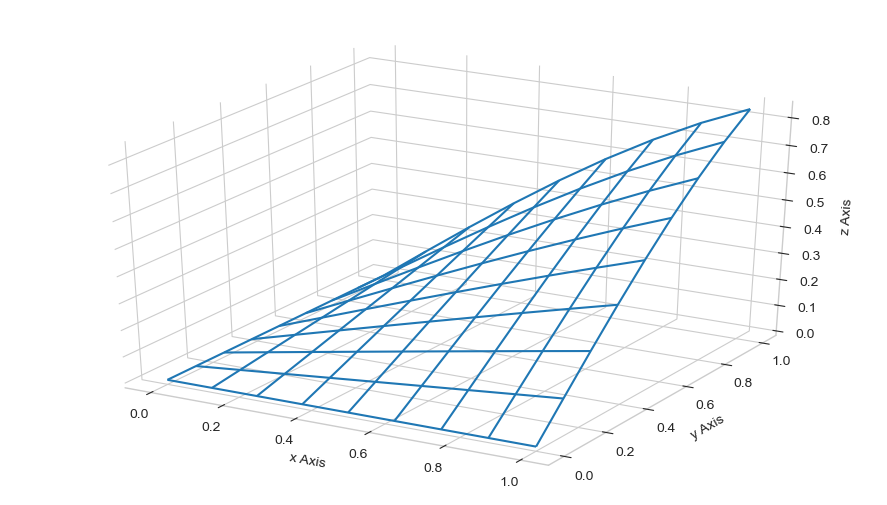

In [6]:
N = 8
h = 1/N
x, y = np.mgrid[0:1+h:h, 0:1+h:h]
u = solvePoisson(f, v, a, b, N)

fig = plt.figure()
ax = fig.gca(projection="3d")

ax.w_xaxis.pane.set_color("w")
ax.w_yaxis.pane.set_color("w")
ax.w_zaxis.pane.set_color("w")
ax.set_xlabel("x Axis")
ax.set_ylabel("y Axis")
ax.set_zlabel("z Axis")

ax.plot_wireframe(x, y, u)
plt.show()